<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Jupyter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Numerical methods: 11. Finite differences 
## Advection-diffusion-reaction equation in 1D
## Implicit scheme
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

----
In this notebook, we solve a simple **transient advection-diffusion-reaction equation** in one dimension,
using an **implicit** numerical method.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from ipywidgets import interactive
import ipywidgets as widgets

----
## Advection-diffusion-reaction equation

We come back to the full transient advection-diffusion-reaction equation in 1D:
$$
\fbox{$
\frac{\partial c(x,t)}{\partial t} 
= - v \frac{\partial c(x,t)}{\partial x}
+ D \frac{\partial^2 c(x,t)}{\partial x^2}
- \lambda c(x,t)
$}
$$
with
- $x$ [m]  position,
- $t$ [s] time,
- $c$ [-] normalized concentration,
- $v$ [m/s]  velocity,
- $D$ [m$^2$/s] diffusion,
- $\lambda$ [1/s] decay constant.

The **initial condition** is:
$$
c(x,t=0) = c_0(x,0)
$$

----
## Gaussian function

We define the `Gaussian` function with mean $\mu$ and standard deviation $\sigma$:
$$
c(x,t) = e^{-\frac{(x-\mu)^2}{\sigma^2}}
$$
which is a solution of the transient advection equation.

In [2]:
def gaussian(x,mu=2.,sigma=1.):
    # Gauss curve
    f = np.exp(-(x-mu)**2/(sigma)**2)
    return f

def rectangle(x,mu=2.,sigma=1.):
    # rectangle
    f = np.where(np.abs(x-mu/sigma)<1,1,0)
    return f

def triangle(x,mu=2.,sigma=1.):
    # triangle
    f = np.zeros_like(x)
    for i in range(len(x)):
        if (x[i]>=(mu-sigma) and x[i] <= mu):
            x1 = mu-sigma; y1=0.
            x2 = mu;y2=1.
            f[i] = y1 + (y2-y1)/(x2-x1)*(x[i]-x1)
        if (x[i]>=mu and x[i] <= mu+sigma):
            x1 = mu; y1=1.
            x2 = mu+sigma;y2=0.
            f[i] = y1 + (y2-y1)/(x2-x1)*(x[i]-x1)
    return f

In [3]:
xstep = 141
x,dx = np.linspace(-2,12,xstep,retstep=True)   # m
print('dx: ',dx)

dx:  0.1


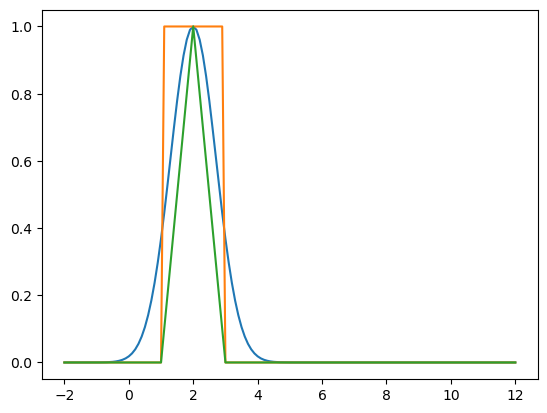

In [4]:
plt.plot(x,gaussian(x))
plt.plot(x,rectangle(x))
plt.plot(x,triangle(x))

----
## Numerical scheme

We use am implicit scheme for advection and diffusion, but keep reaction explicit:
$$
\frac{c_{i}^{n+1}-c_{i}^{n}}{\Delta t}
=
-v \frac{c_{i+1}^{n+1}-c_{i-1}^{n+1}}{2 \Delta x}
+ D \frac{c_{i+1}^{n+1}-2 c_{i}^{n+1} + c_{i-1}^{n+1}}{\Delta x^2}
-\lambda c^n_i
$$
or sorting the $n+1$ time steps to the left, and the $n$ time steps to the right:
$$
c_{i}^{n+1}
+ \frac{v \Delta t}{2 \Delta x} \left( c_{i+1}^{n+1}-c_{i-1}^{n+1} \right)
- \frac{D \Delta t}{\Delta x^2} \left( c_{i+1}^{n+1}-2 c_{i}^{n+1} + c_{i-1}^{n+1} \right)
=
c_{i}^{n} 
- \lambda c^n_i \Delta t
$$
$$
\left( -\frac{v \Delta t}{2 \Delta x} - \frac{D \Delta t}{\Delta x^2} \right) c_{i-1}^{n+1}
+\left( 1 + 2 \frac{D \Delta t}{\Delta x^2} \right) c_{i}^{n+1}
+\left( \frac{v \Delta t}{2 \Delta x} - \frac{D \Delta t}{\Delta x^2} \right) c_{i+1}^{n+1}
=
c_{i}^{n} 
- \lambda c^n_i \Delta t
$$

Use $\alpha=\frac{D \Delta t}{\Delta x^2}$ and $\beta=\frac{v \Delta t}{2 \Delta x}$, then
we arrive at $i=1,n$ equations:
$$
 \left( \underbrace{-\beta-\alpha}_{A_{i,i-1}} \right) c_{i-1}^{n+1}
+\left( \underbrace{1 + 2 \alpha}_{A_{i,i}} \right) c_{i}^{n+1}
+\left( \underbrace{\beta - \alpha}_{A_{i,i+1}} \right) c_{i+1}^{n+1}
=
\underbrace{c_{i}^{n} - \lambda c^n_i \Delta t}_{b_i}
$$
which can be recasted to
$$
A_{ij} c_j^{n+1} = b_j^{n}
$$
This linear system of equations can be solved with appropriate solvers.

<img src="images/PDE_FTCS.jpg" style="height:5cm;">

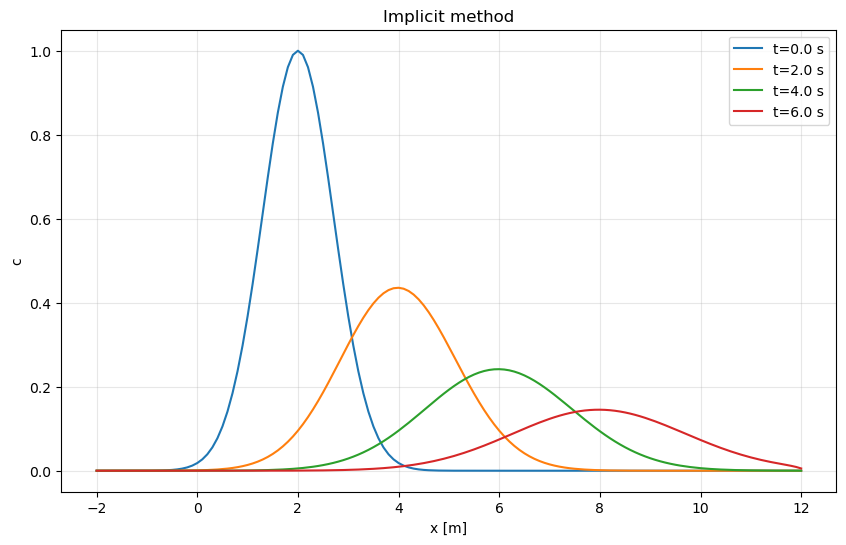

In [5]:
def AdvDiffReact(v=0,D=0,thalf=1000,type=0):
    # define time step from Courant criteria, use 0.1s if v=D=0
    dtadv = np.nan; dtdiff = np.nan
    if (D != 0):
        dtdiff = 0.2*dx**2/D
    if (v != 0):
        dtadv = 0.2*dx/v
    dt = np.nanmin([dtdiff,dtadv,0.01])
    # set time array
    time = np.arange(0,8,dt)
    # set alpha for diffusion and define thalf=100 as no decay
    alpha = D*dt/dx/dx
    beta  = v*dt/2/dx
    if (thalf < 100):
        lamb  = np.log(2)/thalf
    else:
        lamb = 0.
    # set array for velocities
    nt = time.shape[0]
    nx = x.shape[0]
    # initialise matrix A and rhs vector b
    A = np.zeros(nx*nx).reshape(nx,nx)
    b = np.zeros(nx)
    U = np.zeros(nt*nx).reshape(nx,nt)
    u = np.zeros(nx)
    # initial step
    if (type==0):
        U[:,0] = gaussian(x)
    elif (type==1):
        U[:,0] = rectangle(x)
    elif (type==2):
        U[:,0] = triangle(x)
    # time iteration
    for n in range(1,time.shape[0]):
        uold = U[:,n-1]
        for i in range(u.shape[0]):
            # fill matrix
            if (i != 0):
                A[i,i-1] = -beta-alpha
            A[i,i]   = 1 + 2*alpha
            if (i != len(u)-1):
                A[i,i+1] = beta-alpha
            # fill rhs vector  
            b[i] = uold[i] - lamb*uold[i]*dt
        # solve linear sytem
        u = np.linalg.solve(A,b)
        U[:,n] = u
    # plot
    plt.figure(figsize=(10,6))
    plt.xlabel('x [m]')
    plt.ylabel('c')
    plt.grid(alpha=0.3)
    plt.title('Implicit method')
    for j in range(0,U.shape[1]):
        if (np.abs(time[j]-0) < 0.0001):
            plt.plot(x,U[:,j],label='t='+str(round(time[j],1))+' s')
        if (np.abs(time[j]-2) < 0.0001):
            plt.plot(x,U[:,j],label='t='+str(round(time[j],1))+' s')
        if (np.abs(time[j]-4) < 0.0001):
            plt.plot(x,U[:,j],label='t='+str(round(time[j],1))+' s')
        if (np.abs(time[j]-6) < 0.0001):
            plt.plot(x,U[:,j],label='t='+str(round(time[j],1))+' s')
        if (np.abs(time[j]-8) < 0.0001):
            plt.plot(x,U[:,j],label='t='+str(round(time[j],1))+' s')
    plt.legend()
    return A

A = AdvDiffReact(v=1,D=0.2,thalf=4,type=0)

Plot non-zero components of matrix **A**

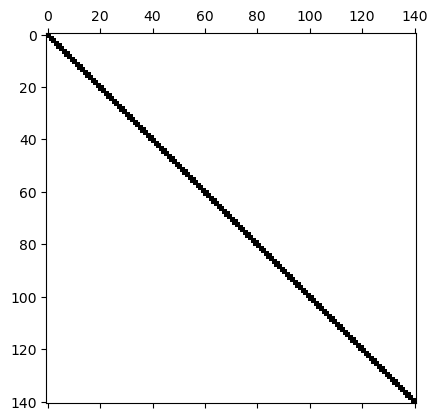

In [6]:
plt.spy(A)

----
## Parameter values and implementation

We define **advection velocity** $v$, diffusivity $D$, and decay constant $\lambda$
later in the function `AdvDiffReact(v,D,thalf)`.
We use the FTCS method:

In [7]:
# call interactive module
interactive_plot = interactive(AdvDiffReact,
                               type=widgets.Dropdown(options=[('gaussian', 0),  
                               ('rectangular', 1),
                               ('triangular', 2)],value=0,description='Type:'),
                               v=widgets.FloatSlider(min=0,max=1,step=0.1,value=1,description='v [m/s]'),
                               D=widgets.FloatSlider(min=0,max=0.5,step=0.02,value=0.2,description='D [m2/s]'),
                               thalf=widgets.FloatSlider(min=1,max=100,step=0.1,value=4,description='thalf [1/s]')
                               
                              )
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='v [m/s]', max=1.0), FloatSlider(value=0.2, descripti…

... done